# aFRR Energy Market & Weather Data Analysis – Finland (EU)

## Context
This notebook analyzes Finland’s Automatic Frequency Restoration Reserve (aFRR)
energy market, which is part of the European electricity balancing mechanism.
The aFRR market is used by transmission system operators to stabilize grid
frequency in real time, especially under high renewable energy penetration.

## Dataset
Hourly data from June 2024 to March 2025 including:
- aFRR Up- and Down-regulation prices
- aFRR capacity market prices
- Day-ahead spot electricity prices
- Weather indicators (temperature, wind, etc.)
- Electricity consumption and demand metrics

## Objective
The goals of this analysis are:
- To understand price behavior and volatility in aFRR Up and Down markets
- To study the relationship between weather, demand, and balancing prices
- To prepare features for aFRR price forecasting models

## Scope
This notebook focuses on exploratory data analysis and basic preprocessing.
Modeling and forecasting are handled in later notebooks.


In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

sns.set_theme(style="whitegrid")

%matplotlib inline



In [22]:
# Load dataset


data_path = r"E:\archive (1)\extended_data_v2.csv"

try:
    df = pd.read_csv(data_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"File not found at: {data_path}")
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")

# Preview data
df.head()


Data loaded successfully.


,datetime,Up,Down,sp,cloud_amount,wind_speed,precipitation_amount,pressure,air_temperature,relative_humidity,wind_direction,Down_Cap,Up_Cap,is_public_holiday,electricity_consumption,electricity_consumption_Finnish_networks,electricity_consumption_forecast
0,2024-06-20 22:00:00+00:00,33.928959,-30.733325,-2.00,1.811111,2.353333,0.0,1006.774444,11.573333,84.877778,249.433333,23.82,9.8,1,25735.78,3617520.070,26816.5
1,2024-06-20 23:00:00+00:00,29.836211,-31.185171,-2.43,1.811111,2.311111,0.0,1006.784444,10.880000,86.966667,246.788889,0.00,0.0,1,25082.63,3447580.368,26178.8
2,2024-06-21 00:00:00+00:00,25.743463,-26.234159,-5.01,1.566667,2.248889,0.0,1006.781111,10.563333,86.144444,253.977778,0.00,0.0,1,24950.97,3328815.372,25513.2
3,2024-06-21 01:00:00+00:00,21.650715,-21.283147,-6.58,2.133333,2.278889,0.0,1006.750000,10.505556,85.588889,242.055556,0.00,0.0,1,24850.31,3248613.632,25324.4
4,2024-06-21 02:00:00+00:00,17.557967,-16.332135,-2.51,3.111111,2.356667,0.0,1006.848889,11.137778,84.488889,253.366667,0.00,0.0,1,25193.84,3265733.750,25520.7


In [24]:
# Dataset overview
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   datetime                                  6456 non-null   object 
 1   Up                                        6456 non-null   float64
 2   Down                                      6456 non-null   float64
 3   sp                                        6456 non-null   float64
 4   cloud_amount                              6456 non-null   float64
 5   wind_speed                                6456 non-null   float64
 6   precipitation_amount                      6456 non-null   float64
 7   pressure                                  6456 non-null   float64
 8   air_temperature                           6456 non-null   float64
 9   relative_humidity                         6456 non-null   float64
 10  wind_direction                      

In [26]:
# Datetime parsing

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Check for failed datetime parsing
invalid_datetime = df["datetime"].isna().sum()
print(f"Invalid datetime entries after parsing: {invalid_datetime}")


Invalid datetime entries after parsing: 0


In [28]:
# Missing value analysis

missing_values = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .query("missing_count > 0")
)

missing_values


,missing_count


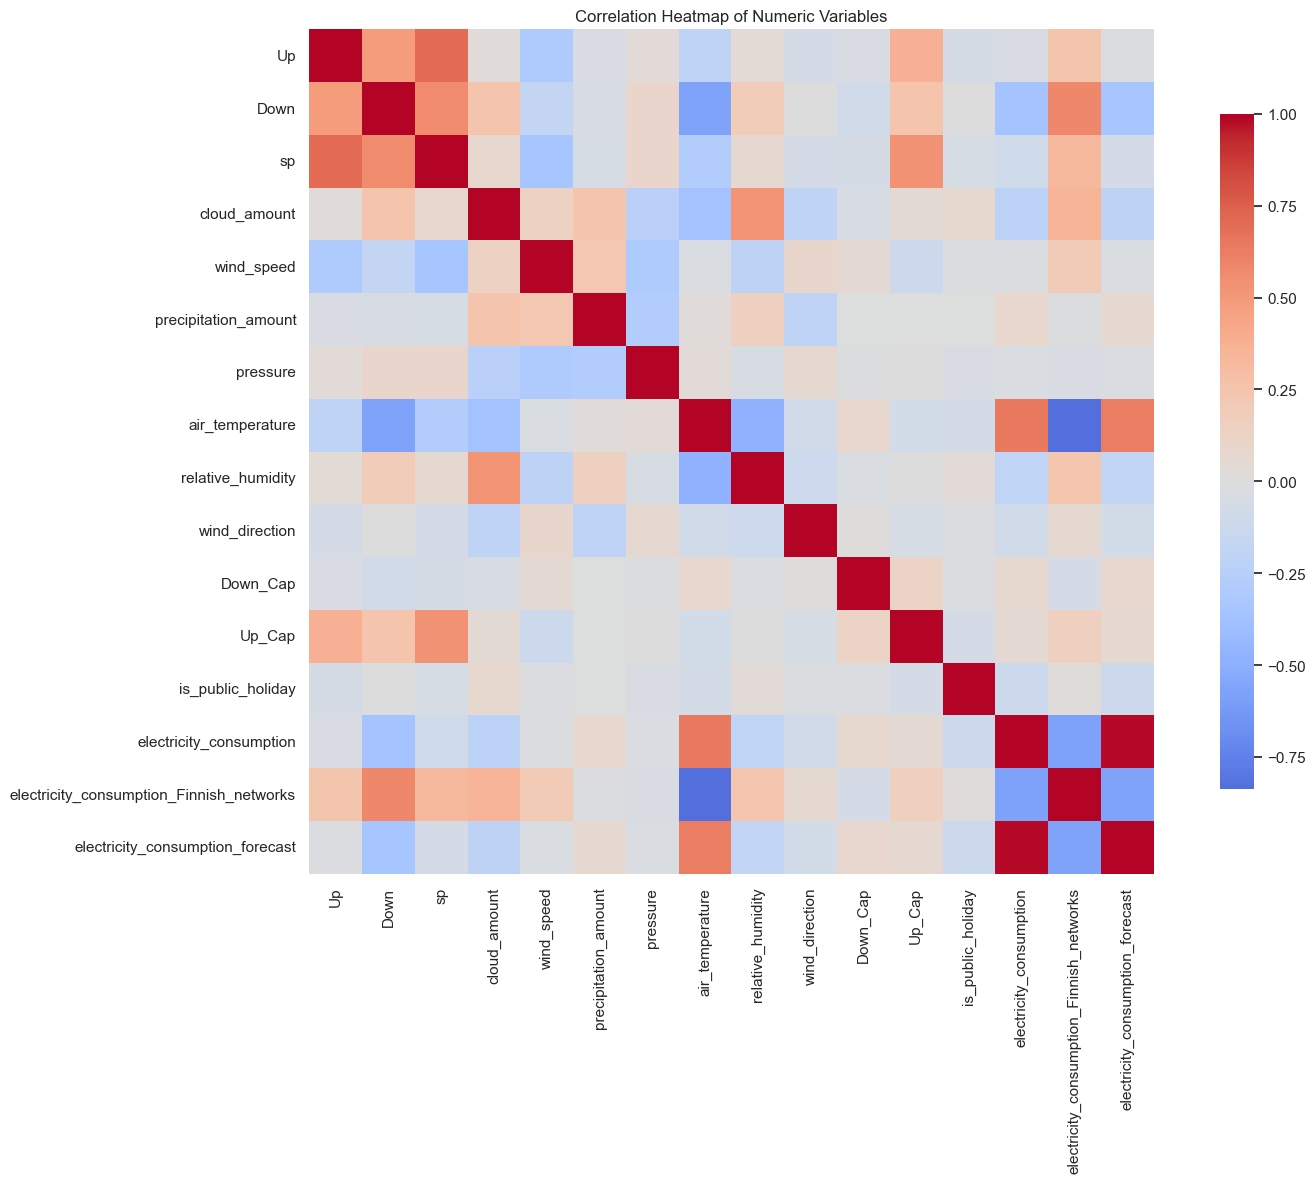

In [32]:
# Correlation Heatmap (Numeric Variables)

numeric_df = df.select_dtypes(include="number")
n_num = numeric_df.shape[1]

if n_num >= 4:
    corr = numeric_df.corr(numeric_only=True)

    plt.figure(figsize=(min(16, 1.2 * n_num), min(12, 1.0 * n_num)))
    sns.heatmap(
        corr,
        cmap="coolwarm",
        center=0,
        square=True,
        annot=False,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Correlation Heatmap of Numeric Variables")
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipped: only {n_num} numeric columns available.")


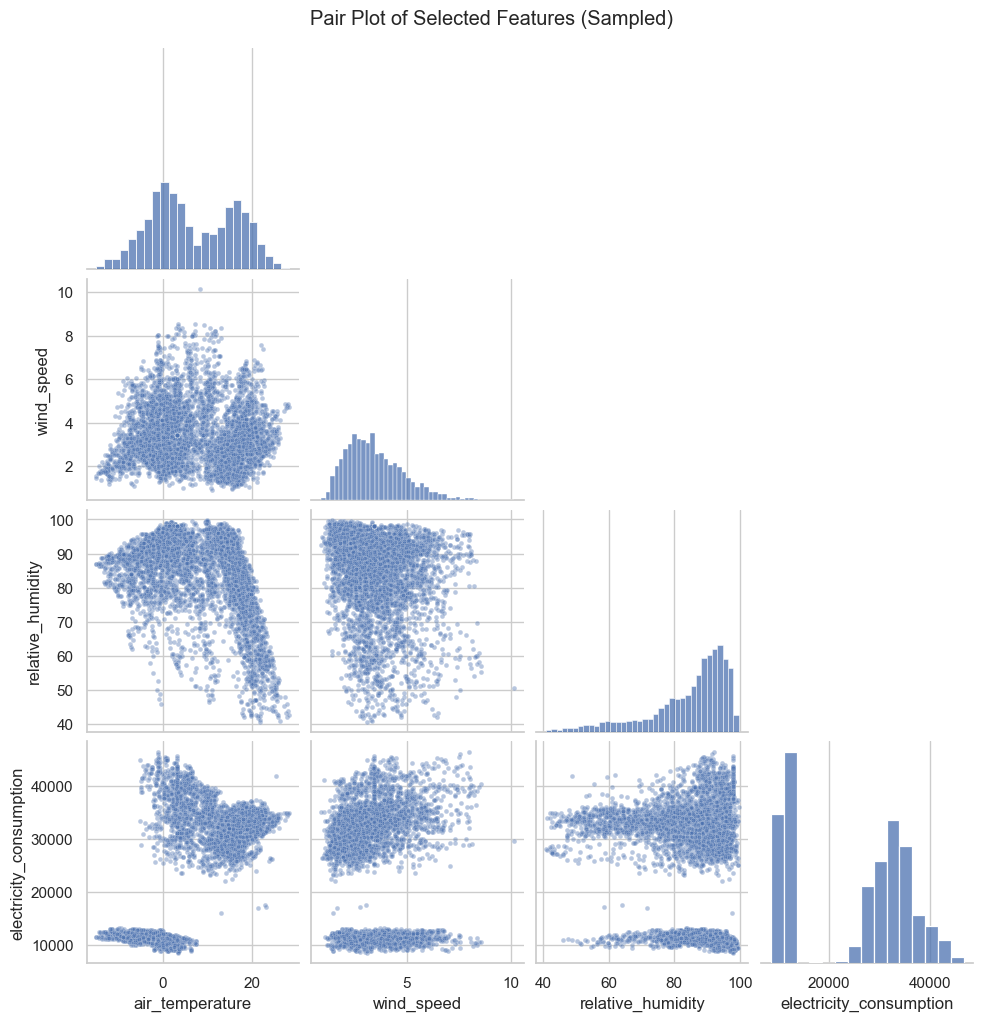

In [34]:
# Pair Plot (Selected Features)

selected_features = [
    "air_temperature",
    "wind_speed",
    "relative_humidity",
    "electricity_consumption"
]

if set(selected_features).issubset(df.columns):
    plot_df = df[selected_features].dropna()

    if len(plot_df) > 5000:
        plot_df = plot_df.sample(5000, random_state=42)

    sns.pairplot(plot_df, corner=True, plot_kws={"alpha": 0.4, "s": 12})
    plt.suptitle("Pair Plot of Selected Features (Sampled)", y=1.02)
    plt.show()
else:
    print("Skipped: some selected features are missing.")


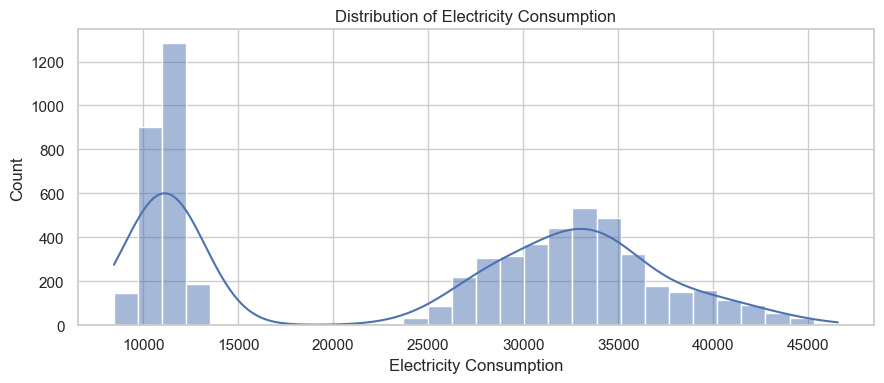

In [36]:
# Histogram: Electricity Consumption

if "electricity_consumption" in df.columns:
    plt.figure(figsize=(9, 4))
    sns.histplot(df["electricity_consumption"].dropna(), bins=30, kde=True)
    plt.title("Distribution of Electricity Consumption")
    plt.xlabel("Electricity Consumption")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column electricity_consumption not found.")


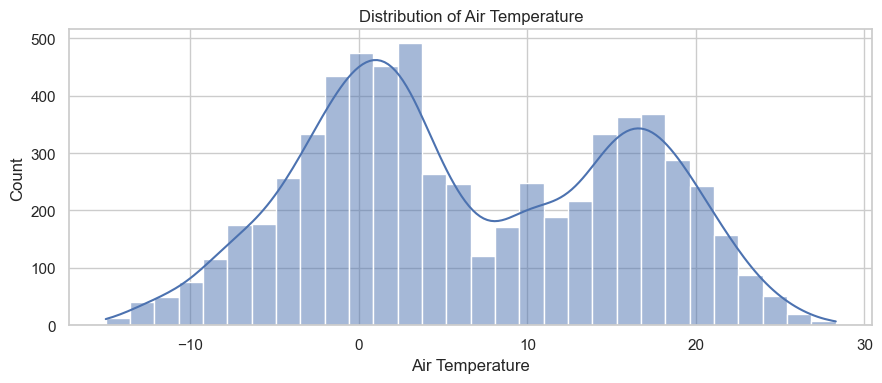

In [38]:
# Histogram: Air Temperature

if "air_temperature" in df.columns:
    plt.figure(figsize=(9, 4))
    sns.histplot(df["air_temperature"].dropna(), bins=30, kde=True)
    plt.title("Distribution of Air Temperature")
    plt.xlabel("Air Temperature")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column air_temperature not found.")


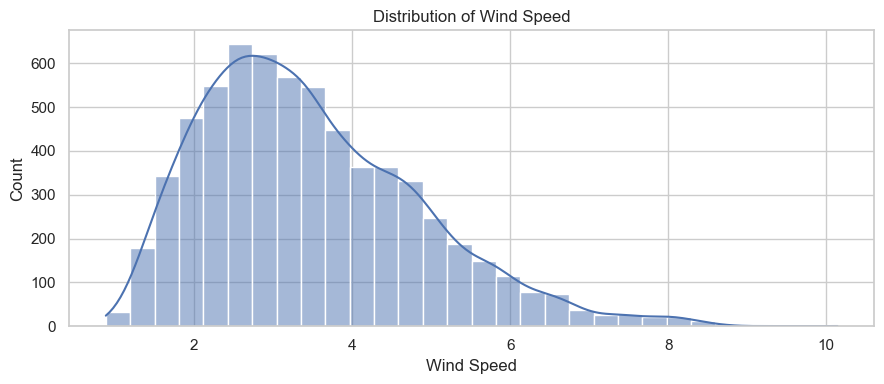

In [40]:
# Histogram: Wind Speed

if "wind_speed" in df.columns:
    plt.figure(figsize=(9, 4))
    sns.histplot(df["wind_speed"].dropna(), bins=30, kde=True)
    plt.title("Distribution of Wind Speed")
    plt.xlabel("Wind Speed")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column wind_speed not found.")


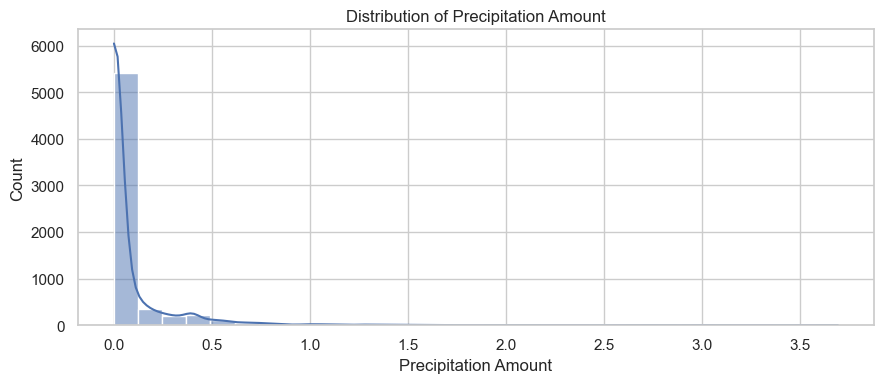

In [42]:
# Histogram: Precipitation Amount

if "precipitation_amount" in df.columns:
    plt.figure(figsize=(9, 4))
    sns.histplot(df["precipitation_amount"].dropna(), bins=30, kde=True)
    plt.title("Distribution of Precipitation Amount")
    plt.xlabel("Precipitation Amount")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column precipitation_amount not found.")


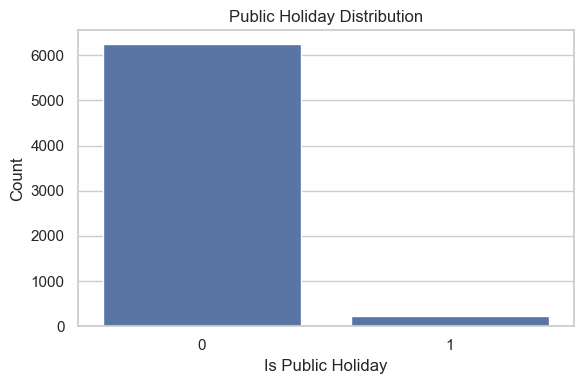

In [44]:
# Count Plot: Public Holiday

if "is_public_holiday" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x="is_public_holiday")
    plt.title("Public Holiday Distribution")
    plt.xlabel("Is Public Holiday")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column is_public_holiday not found.")


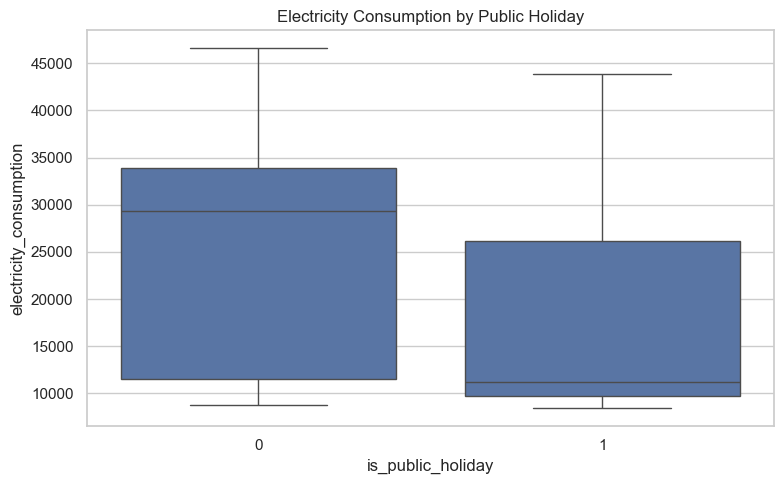

In [46]:
# Box Plot: Electricity Consumption by Holiday

if {"electricity_consumption", "is_public_holiday"}.issubset(df.columns):
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df,
        x="is_public_holiday",
        y="electricity_consumption"
    )
    plt.title("Electricity Consumption by Public Holiday")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns missing for box plot.")


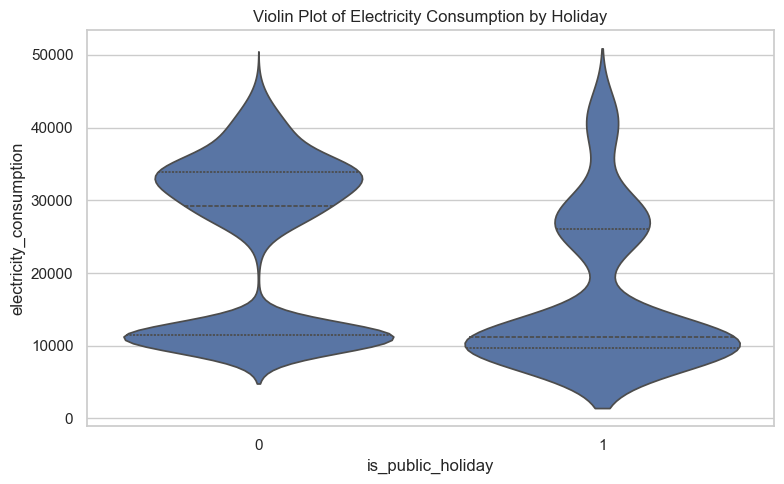

In [48]:
# Violin Plot: Consumption by Holiday

if {"electricity_consumption", "is_public_holiday"}.issubset(df.columns):
    plt.figure(figsize=(8, 5))
    sns.violinplot(
        data=df,
        x="is_public_holiday",
        y="electricity_consumption",
        inner="quartile"
    )
    plt.title("Violin Plot of Electricity Consumption by Holiday")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns missing for violin plot.")


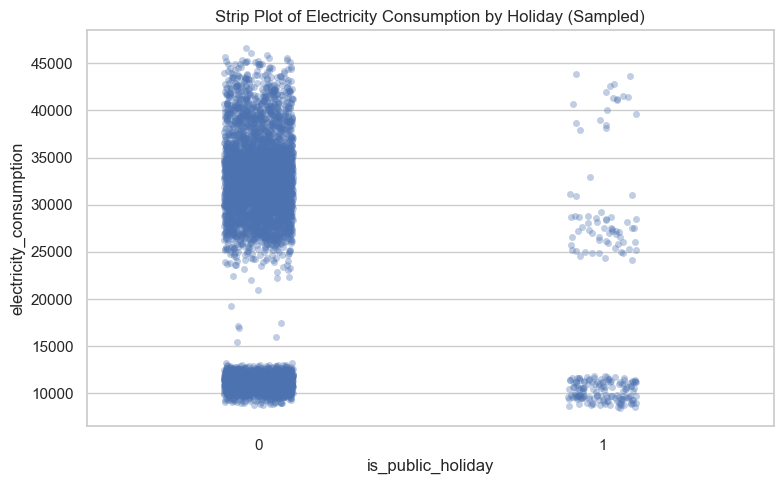

In [50]:
# Strip Plot: Consumption by Holiday (Sampled)

if {"electricity_consumption", "is_public_holiday"}.issubset(df.columns):
    tmp = df[["electricity_consumption", "is_public_holiday"]].dropna()

    if len(tmp) > 8000:
        tmp = tmp.sample(8000, random_state=42)

    plt.figure(figsize=(8, 5))
    sns.stripplot(
        data=tmp,
        x="is_public_holiday",
        y="electricity_consumption",
        jitter=True,
        alpha=0.35
    )
    plt.title("Strip Plot of Electricity Consumption by Holiday (Sampled)")
    plt.tight_layout()
    plt.show()
else:
    print("Required columns missing for strip plot.")


In [52]:
# Target and feature definition

TARGET = "electricity_consumption"

EXCLUDE_COLS = {
    "datetime",
    "electricity_consumption",
    "electricity_consumption_forecast"
}

feature_cols = [
    c for c in df.columns
    if c not in EXCLUDE_COLS
]

print(f"Number of raw feature columns: {len(feature_cols)}")


Number of raw feature columns: 14


In [54]:
# Numeric feature filtering

X = df[feature_cols].select_dtypes(include="number")
y = df[TARGET]

print(f"Numeric features used: {X.shape[1]}")
print(f"Target missing values: {y.isna().sum()}")

Numeric features used: 14
Target missing values: 0


In [56]:
X = X.fillna(X.median())
y = y.fillna(y.median())

In [58]:
# Time-based train–test split

split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 5164
Test samples: 1292


In [60]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [62]:
r2 = r2_score(y_test, y_pred)
print(f"Baseline Linear Regression R²: {r2:.3f}")

Baseline Linear Regression R²: -195.915


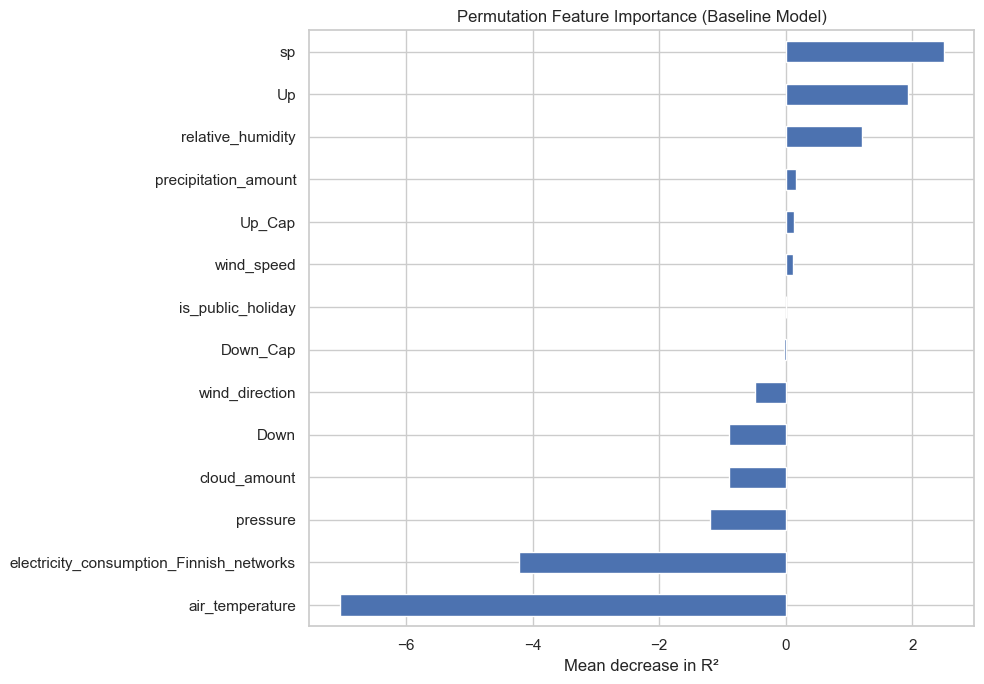

In [66]:
# Permutation importance

perm = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importance = (
    pd.Series(perm.importances_mean, index=X.columns)
      .sort_values()
)

plt.figure(figsize=(10, 7))
importance.plot(kind="barh")
plt.xlabel("Mean decrease in R²")
plt.title("Permutation Feature Importance (Baseline Model)")
plt.tight_layout()
plt.show()

## Conclusion and Future Work

This notebook explored Finland’s aFRR energy market and associated weather and
demand variables through structured exploratory data analysis and a baseline
predictive modeling exercise. The visual analysis highlighted meaningful
relationships between electricity consumption, weather conditions, and calendar
effects, confirming the strong seasonal and temporal nature of the data.

A simple linear regression model was implemented as a baseline to assess whether
the available features contain predictive signal for electricity consumption.
While the resulting R² score indicates the presence of linear relationships, the
model is intentionally limited and should not be interpreted as a forecasting
solution. Its primary purpose is to serve as a reference point for more suitable
time-aware models.

Future work should focus on methods that explicitly account for temporal
dependencies, such as time-series regression, autoregressive models, or machine
learning approaches with lagged features. Additional improvements may include
richer feature engineering (hour-of-day, day-of-week, seasonal indicators),
testing non-linear models such as tree-based or ensemble methods, and integrating
external data sources to better capture system dynamics.

Overall, this notebook establishes a solid exploratory and methodological
foundation for more advanced energy market modeling and forecasting tasks.
